In [40]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import make_pipeline

In [41]:
# Parameters
test_set_size = 0.2  # [0.2, 0.6, 0.8]
randomized_labels = True
mislabel_percentage = 90  # Percentage decimals numbers: 0-100
standardize = False
apply_pca = False
apply_anova = True
feature_variance_threshold = 5
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [42]:
# Load data
file_path_data = "TCGAdata.txt"
file_path_labels = "TCGAlabels.txt"
df_data = pd.read_csv(file_path_data, delim_whitespace=True, header=0, quotechar='"')
df_labels = pd.read_csv(
    file_path_labels, delim_whitespace=True, header=0, quotechar='"'
)
df = pd.merge(df_data, df_labels, left_index=True, right_index=True, how="left")

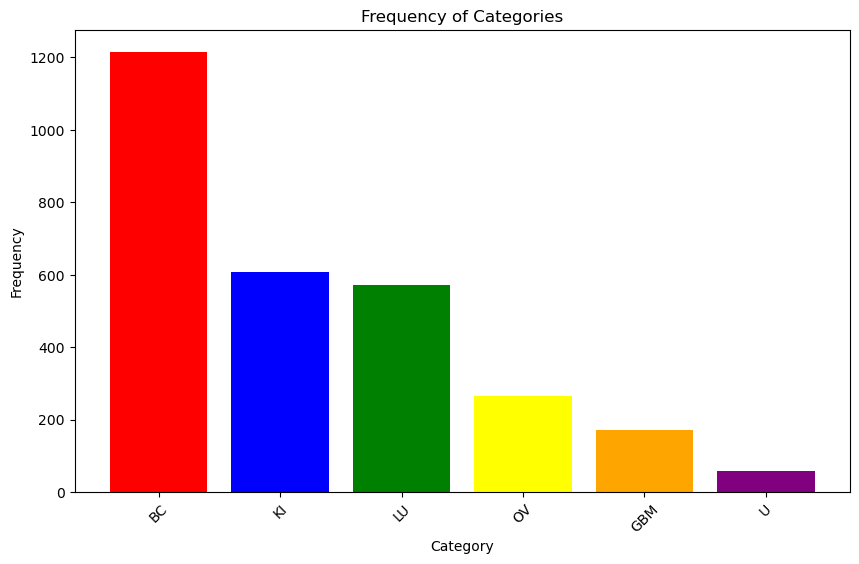

In [43]:
category_counts = df.iloc[:, -1].value_counts()
class_colors = {
    "BC": "red",
    "KI": "blue",
    "LU": "green",
    "OV": "yellow",
    "GBM": "orange",
    "U": "purple",
}
colors = [class_colors.get(category, "gray") for category in category_counts.index]

plt.figure(figsize=(10, 6))
plt.bar(category_counts.index, category_counts.values, color=colors)
plt.xlabel("Category")
plt.ylabel("Frequency")
plt.title("Frequency of Categories")
plt.xticks(rotation=45)

plt.show()

In [44]:
# Classifiers
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, n_jobs=-1),
    "KNN": KNeighborsClassifier(n_neighbors=20),
}

In [45]:
X = df.iloc[:, :-1]  # Features
y = df.iloc[:, -1]  # Labels
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_set_size, random_state=42
)

In [46]:
# Function to mislabel a percentage of the data
def randomize_labels(labels, percentage):
    n_total = len(labels)
    n_change = int(n_total * (percentage / 100))
    indices_to_change = np.random.choice(n_total, n_change, replace=False)
    unique_labels = np.unique(labels)

    # Mislabeling logic
    new_labels = labels.copy()
    for index in indices_to_change:
        original_label = labels.iloc[index]
        possible_labels = unique_labels[unique_labels != original_label]
        new_labels.iloc[index] = np.random.choice(possible_labels)
    return new_labels, indices_to_change

In [47]:
if randomized_labels:
    y_train_randomized, indices_change = randomize_labels(
        y_train, percentage=mislabel_percentage
    )
    y_train = y_train_randomized
    print("Successful randomization of labels")

Successful randomization of labels


In [48]:
if apply_anova:
    sel = VarianceThreshold(threshold=feature_variance_threshold)
    X_train = sel.fit_transform(X_train)
    X_test = sel.transform(X_test)

    max_features = min(100, X_train.shape[1])
    feature_range = range(1, max_features + 1, 5)
    best_features = {name: (0, 0) for name in classifiers}
    for name, clf in classifiers.items():
        best_score = 0
        for n_features in feature_range:
            anova = SelectKBest(f_classif, k=n_features)
            X_train_anova = anova.fit_transform(X_train, y_train)
            cv_scores = cross_val_score(clf, X_train_anova, y_train, cv=kf)
            mean_cv_score = np.mean(cv_scores)
            if mean_cv_score > best_score:
                best_score = mean_cv_score
                best_features[name] = (n_features, best_score)
        print(
            f"The best number of features for {name} is {best_features[name][0]} with a score of {best_features[name][1]}."
        )

if standardize:
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)

kf = KFold(n_splits=5, shuffle=True, random_state=42)


if apply_pca:
    best_components = {name: (0, 0) for name in classifiers}
    for name, clf in classifiers.items():
        best_score = 0
        for components in range(10, 21):
            pca = PCA(n_components=components)
            X_train_pca = pca.fit_transform(X_train)
            cv_scores = cross_val_score(clf, X_train_pca, y_train, cv=kf)
            mean_cv_score = np.mean(cv_scores)
            if mean_cv_score > best_score:
                best_score = mean_cv_score
                best_components[name] = (components, best_score)
        print(
            f"The best number of principal components for {name} is {best_components[name][0]} with a score of {best_components[name][1]}."
        )

The best number of features for Logistic Regression is 6 with a score of 0.18839056821703243.
The best number of features for Random Forest is 76 with a score of 0.1879698753885305.
The best number of features for KNN is 61 with a score of 0.19748992872637125.


Validation score: 0.18839056821703243
Logistic Regression: 0.010380622837370242
Validation score: 0.17626184372388282
Random Forest: 0.02422145328719723
Validation score: 0.19748992872637125
KNN: 0.025951557093425604


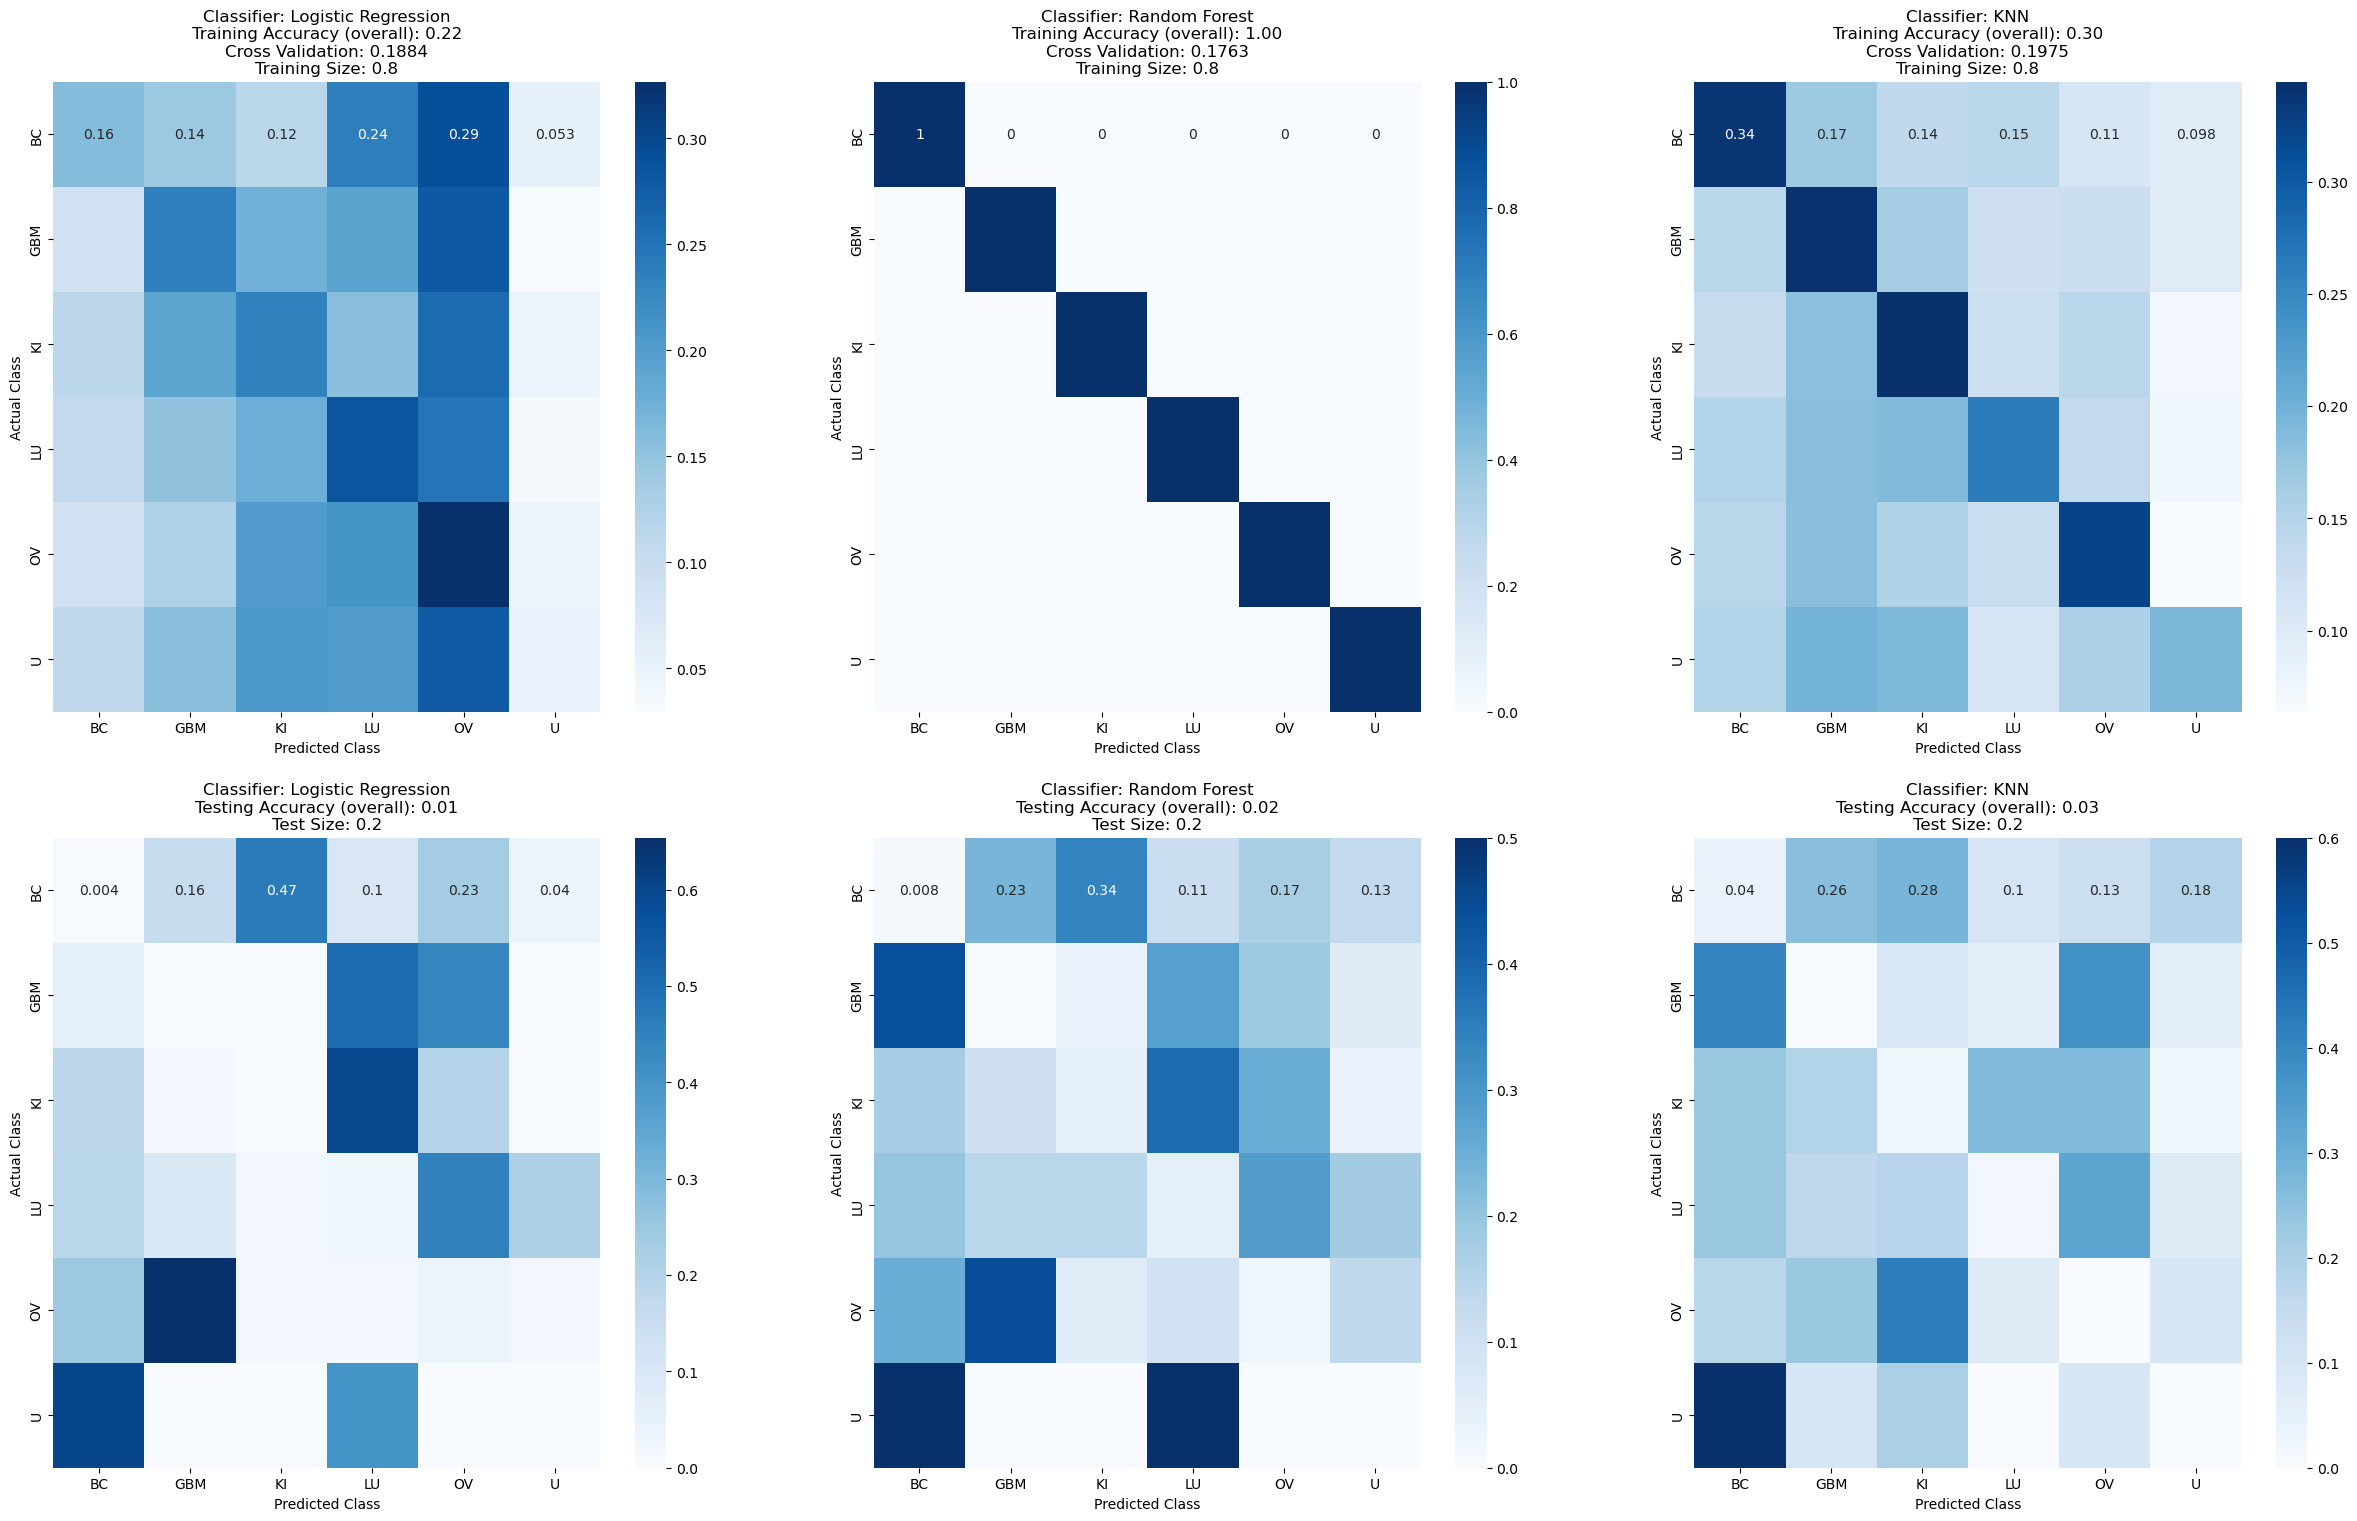

In [49]:
i = 0
plt.figure(figsize=(30, 18))
for name, clf in classifiers.items():
    i += 1 
    X_train_copy = X_train.copy()
    X_test_copy = X_test.copy()

    if apply_anova:
        anova = SelectKBest(f_classif, k=best_features[name][0])
        X_train_copy = anova.fit_transform(X_train_copy, y_train)
        X_test_copy = anova.transform(X_test_copy)

    if apply_pca:
        pca = PCA(n_components=best_components[name][0])
        X_train_copy = pca.fit_transform(X_train_copy)
        X_test_copy = pca.transform(X_test_copy)

    ### Training Score###
    cv_scores = cross_val_score(clf, X_train_copy, y_train, cv=kf)
    clf.fit(X_train_copy, y_train)
    y_pred_train = clf.predict(X_train_copy)
    accuracy = accuracy_score(y_train, y_pred_train)
    cm = confusion_matrix(y_train, y_pred_train, normalize="true")
    class_labels = sorted(set(y_train))
    print(f"Validation score: {np.mean(cv_scores)}")
    plt.subplot(2, 3, i)
    sns.heatmap(
        cm, annot=True, cmap="Blues", xticklabels=class_labels, yticklabels=class_labels
    )
    plt.title(
        f"Classifier: {name}\nTraining Accuracy (overall): {accuracy:.2f}\nCross Validation: {np.mean(cv_scores):.4f}\nTraining Size: {(1-test_set_size):.1f}"
    )
    plt.ylabel("Actual Class")
    plt.xlabel("Predicted Class")

    ### Test score ####
    y_pred_test = clf.predict(X_test_copy)
    accuracy = accuracy_score(y_test, y_pred_test)
    cm = confusion_matrix(y_test, y_pred_test, normalize="true")
    class_labels = sorted(set(y_test))
    plt.subplot(2, 3, i+3)
    sns.heatmap(
        cm, annot=True, cmap="Blues", xticklabels=class_labels, yticklabels=class_labels
    )
    plt.title(
        f"Classifier: {name}\nTesting Accuracy (overall): {accuracy:.2f}\nTest Size: {test_set_size}"
    )
    plt.ylabel("Actual Class")
    plt.xlabel("Predicted Class")

    print(f"{name}: {accuracy}")
plt.show()